## Water Rocket Simulator

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import numpy as np
import pandas as pd

In [2]:
# Function to conversion to Internation Units and vice-versa:
# Use: toUnit[to unit][from unit](value)

toUnit = {}
toUnit ['m']   = {'mm' :lambda u: u*1E-3}
toUnit ['mm']  = {'m'  :lambda u: u*1E3}
toUnit ['m3']  = {'l'  :lambda u: u*1E-3,   
                  'ml' :lambda u: u*1E-6}

toUnit ['ms']  = {'s'  :lambda u: u*1E3}

toUnit ['l']   = {'m3' :lambda u: u*1E3,    
                  'ml' :lambda u: u*1E3}
toUnit ['ml']  = {'l'  :lambda u: u*1E3,    
                  'm3' :lambda u: u*1E+6}

toUnit ['kg']  = {'g'  :lambda u: u*1E-3}
toUnit ['g']   = {'kg' :lambda u: u*1E3}

toUnit ['Pa']  = {'psi':lambda u: u*6_894.8}
toUnit ['psi'] = {'Pa' :lambda u: u/6_894.8}

toUnit ['K']  =  {'C'  :lambda u: 273+u}
toUnit ['C']  =  {'K'  :lambda u: u-273}

toUnit ['Gs'] =  {'m/s2': lambda u: u/9.81}

### Parameters:
$\text{δt}$ = 0.001 (s) : Time interval for intergration<BR>
<LI>r_nozzle : Nozzle radius (mm)<BR>
<LI>p_launch : Launch pressure (psi)<BR>
<LI>vol_water = 500 ml: Water volume at launch
<LI>vol_rocket = 1500 ml : Volume inside rocket
<LI>Cd = 0.4
    
### Constants:
$g$ = 9.81 m/s^2: gravitational acceleration<BR>
γ = 1.4 : adiabatic constant for air<BR>
ρ_water = 1000 kg/m^3 : density of water<BR>
p_atmospheric = 99.036 Pa<BR>
R = 8.3145 J/(mol K) : Ideal gas constant<BR>
Air average molar mass = 28.9 g/mol<BR>

### Experimental conditions: 
<LI>City: Oberusel
<LI>Elevation: 197m over sea level
<LI>temperature: 22oC
<LI>$z$ = 0 m: Initial height<BR>
<LI>$v$ = 0 m/s: Initial speed<BR>

    
### Conversion factors:
1 psi = 6894.8 Pa



In [3]:
# Constants:
g = 9.81
γ = 1.4
ρ_water = 1_000
R = 8.3145

In [4]:
# Parameters:
z_initial = 0
v_initial = 0
r_nozzle         = toUnit['m']['mm'](7)
p_launch         = toUnit['Pa']['psi'](100)
vol_water_launch = toUnit['m3']['ml'](526)
vol_rocket       = toUnit['m3']['ml'](1500)
m_rocket         = toUnit['kg']['g'](148)
temp_external    = toUnit['K']['C'](22)
p_atmospheric    = 99_036
m_mol_air        = toUnit['kg']['g'](28.9)
ρ_air_external   = p_atmospheric * m_mol_air / (temp_external *R)
Cd               = 0.4

In [21]:
[r_nozzle, p_launch, vol_water_launch,vol_rocket, m_rocket, temp_external, p_atmospheric, m_mol_air, ρ_air_external]

[0.007,
 689480.0,
 0.000526,
 0.0015,
 0.148,
 295,
 99036,
 0.0289,
 1.1668976904753894]

In [5]:
# Integration interval:
δt = 0.001  
t_max = 10

In [6]:
# Calculation of initial conditions:
t_initial = 0
a_initial = 0
vol_air_initial = vol_rocket-vol_water_launch

ρ_air_initial = (p_launch * m_mol_air / (temp_external *R)) * ((vol_air_initial)/vol_rocket) + ρ_air_external
cross_section_rocket = np.pi*(0.045)**2
k_air_drag = 1/2 * ρ_air_external * Cd * cross_section_rocket

In [7]:
def update_parameters (_v,_vol_water,_p_air,_temp_air):
    
    _m_water = _vol_water * ρ_water
    _vol_air = vol_rocket-_vol_water
       
    _m_air = (m_mol_air/R) * ((_p_air) * _vol_air/_temp_air)    
             
    # Water expeled equations: 
    if _vol_water > 0:
        _v_air = 0   # velocity of air leaving the nozzle
        _v_water_expelled = np.sqrt(2*_p_air/ρ_water)
        _vol_water_expelled = (np.pi*(r_nozzle)**2) * _v_water_expelled * δt
        _m_water_expelled = _vol_water_expelled * ρ_water 
        _m_water -= _m_water_expelled
        _vol_water = _m_water/ρ_water
        _vol_air = vol_rocket-_vol_water
        _p_air = p_launch * (vol_air_initial/(_vol_air))**γ    
        
        # Air temperature changes due to the volume change:
        _temp_air = temp_external* (vol_air_initial/_vol_air)**(γ-1)
        
    # Density of air inside the rocket:
    _ρ_air = ((_p_air+p_atmospheric) * m_mol_air / (_temp_air *R))         

        
    # Air expelled equations:
    if _vol_water <= 0 and _p_air >0:
        _v_water = 0
        _v_air = 1.081*np.sqrt(_p_air/_ρ_air)
        _m_air_expelled = (np.pi*(r_nozzle)**2) * _v_air * _ρ_air * δt
        _p_air = ((_m_air-_m_air_expelled)/_m_air)*_p_air
        _m_air -= _m_air_expelled
        # Temperature does not changes in adiabatic expansion when volume is the same
    
    # Total mass of rocket with water and compressed air:
    # OBS: The mass of air is only the extra air in order to avoid the need to calculate the hydrostatic force of air
    _m_total = _m_water + m_rocket + _m_air   
        
    # Forces:    
    # gravity:
    _f_gravity = _m_total * (-g)
    
    # air drag:  
    if _v == 0:
        _f_air_drag = 0
    else:
        _f_air_drag = -_v/np.sqrt(_v**2) * k_air_drag * _v**2
    
    # thrust:
    # thrust due to water being expeled:
    _f_thrust_water = 0
    if _vol_water > 0:
        _f_thrust_water = _m_water_expelled * _v_water_expelled /δt         
            
    # thrust due to air being expeled:
    _f_thrust_air = 0
    if (_vol_water <= 0) and (_p_air > 0):
        _f_thrust_air = _m_air_expelled * _v_air / δt
        
  
    
    # calculate the aceleration
    _a = (_f_gravity + _f_air_drag + _f_thrust_water + _f_thrust_air)/_m_total
    
    # calculate the new state of rocket (water mass, internal air pressure)
            
    return (_a,_vol_water,_p_air,_m_total,_temp_air,_m_air,_f_thrust_water,_f_thrust_air,_f_air_drag)

In [8]:
# INTEGRATION:

# Initialize performance parameters
t_apoggee    = np.nan
z_apoggee    = np.nan
v_max        = np.nan
a_max        = np.nan
t_water_ends = np.nan
t_air_ends   = np.nan

# Initialize the lists to execute the numerical integrals:
T = np.array([],float)
Z = np.array([],float)
V = np.array([],float)
A = np.array([],float)
VOL_WATER = np.array([],float)
P = np.array([],float) # Pressure inside the rocket (above external air)
M_AIR = np.array([],float) # Mass of air inside the rocket (total)
F_THRUST_WATER = np.array([],float)
F_THRUST_AIR   = np.array([],float)
F_AIR_DRAG     = np.array([],float)
TEMP_AIR = np.array([],float)

# Trajectory calculation
z_ = z_initial
v_ = v_initial
temp_air_ = temp_external
vol_water_ = vol_water_launch
p_air_  = p_launch
a_      = a_initial
t_      = t_initial     

(_a0,_vol_water0,_p_air0,_m_total0,_temp_air0,m_air_,f_thrust_water_,f_thrust_air_,f_air_drag_) = update_parameters (v_initial,vol_water_launch,p_launch,temp_external)

while t_ <= t_max:
    z_prior       = z_
    v_prior       = v_
    vol_water_prior = vol_water_
    p_prior       = p_air_
    temp_air_prior = temp_air_
    
    T = np.append(T,t_)
    Z = np.append(Z,z_)
    V = np.append(V,v_)
    A = np.append(A,a_)
    VOL_WATER = np.append(VOL_WATER,vol_water_)
    P = np.append(P,p_air_)
    M_AIR = np.append(M_AIR,m_air_)
    F_THRUST_WATER = np.append(F_THRUST_WATER,f_thrust_water_)
    F_THRUST_AIR   = np.append(F_THRUST_AIR  ,f_thrust_air_)
    F_AIR_DRAG     = np.append(F_AIR_DRAG    ,f_air_drag_)
    TEMP_AIR = np.append(TEMP_AIR,temp_air_)
       
    (a_,vol_water_,p_air_,_m_total,temp_air_,m_air_,f_thrust_water_,f_thrust_air_,f_air_drag_) = update_parameters (v_prior,vol_water_prior,p_prior,temp_air_prior)
    v_ = v_prior + a_ * δt
    z_ = z_prior + v_ * δt
      
    
    ################
    # Find trajectory parameters reported from ALTIMETER 2:
    
    # t_thrust: Time when thrust ended (p_=0)
    
    # Apoggee:
    if (np.isnan(z_apoggee)) and (z_ < z_prior): 
        z_apoggee = z_prior
        t_apoggee = t_            
    
    # End of water:
    if (np.isnan(t_water_ends)) and (vol_water_ <= 0):        
        vol_water_ = 0
        t_water_ends = t_
        # Energy in the end of water:
        energy_thrust_water = (1/2)*_m_total*(v_prior**2) + _m_total*g*z_prior
        
    # End of pressurized air:
    if (np.isnan(t_air_ends)) and (p_air_ <= 0):                
        t_air_ends = t_
        # Energy due to pressurized air:
        energy_thrust_air = (1/2)*_m_total*(v_prior**2) + _m_total*g*z_prior - energy_thrust_water
        a_average_thrust = (v_ - v_initial)/t_
        t_thrust_time = t_
        
    # Top speed:
    if (np.isnan(v_max)) and (v_ < v_prior):
        v_max = v_prior      
        
    
    # Landing conditions:
    if z_ <= 0:
        z_ = 0
        v_ = 0
        a_ = 0
    
    # update t:
    t_ += δt

TOTAL_ROCKET_MASS = M_AIR + VOL_WATER*ρ_water+ m_rocket

In [9]:
def plot_trajectory():
    # Plot the results of integrals (Simulation)
    figsize (15,5)
    graph_textbox_low = dict(boxstyle='round', facecolor='#008000', alpha=0.3)
    graph_textbox_corner = dict(boxstyle='round', facecolor='yellow', alpha=0.3)
    parameters = f"nozzle:   {toUnit['mm']['m'](r_nozzle)*2:2.1f} mm"+'\n'+f'P launch:{toUnit["psi"]["Pa"](p_launch):2.0f} psi'

    # Plotting range: TIME
    # 
    plot_t_max = int(t_apoggee*2+1)
    #plot_t_max = t_max

    fig,ax = plt.subplots(1,3)
    plt.suptitle ('Simulation:Trajectory')
    ax[0].plot(T,Z,color='#0000FF')
    ax[0].set_ylabel('m')
    ax[0].set_title('Height')
    ax[0].set_xlim([0,plot_t_max])
    textbox = f"""z apoggee ={z_apoggee:5.1f}  m
    t apoggee =  {t_apoggee:5.2f} s
    t thrust     =   {t_thrust_time:2.2f} s"""
    ax[0].text(plot_t_max*0.15,0, textbox, bbox=graph_textbox_low)
    ax[0].text(plot_t_max*0.60,np.max(Z)*0.97, parameters, bbox=graph_textbox_corner, fontsize=9)

    ax[1].plot(T,V,color='#0000FF')
    ax[1].set_ylabel('m/s')
    ax[1].set_title('Speed')
    ax[1].set_xlim([0,plot_t_max])
    textbox = f'top speed = {v_max:3.1f} m/s'
    ax[1].text(plot_t_max*0.2,np.min(V), textbox, bbox=graph_textbox_low)
    ax[1].text(plot_t_max*0.60,np.max(V)*0.95, parameters, bbox=graph_textbox_corner, fontsize=9)

    ax[2].plot(T,np.sqrt(F_AIR_DRAG**2),color='#FF0000')
    ax[2].set_xlabel('t (s)')
    ax[2].set_ylabel('N')
    ax[2].set_title('|Air Drag|')
    ax[2].set_xlim([0,int(t_apoggee*2+1)])

    plt.show()

In [10]:
def plot_simulation():
    # Plot the results of integrals (Simulation)
    figsize (15,15)
    plot_t_max = t_water_ends+0.2
    graph_textbox_low = dict(boxstyle='round', facecolor='#008000', alpha=0.3)
    graph_textbox_corner = dict(boxstyle='round', facecolor='yellow', alpha=0.3)    
    parameters = f"nozzle:   {toUnit['mm']['m'](r_nozzle)*2:2.1f} mm"+'\n'+f'P launch:{toUnit["psi"]["Pa"](p_launch):2.0f} psi'    

    fig,ax = plt.subplots(3,3)
    plt.suptitle ('Simulation: Source of Thrust => Water volume and Air pressure inside rocket')

    ax[0,0].plot(T,toUnit['ml']['m3'](VOL_WATER),color='#0000FF')
    #ax[0,0].set_xlabel('t (s)')
    ax[0,0].set_ylabel('ml')
    ax[0,0].set_title('Water volume')
    ax[0,0].set_ylim([0,toUnit['ml']['m3'](vol_water_launch)+100])
    ax[0,0].set_xlim([0,plot_t_max])

    ax[0,1].plot(T,toUnit['psi']['Pa'](P),color='#0000FF')
    #ax[0,1].set_xlabel('t (s)')
    ax[0,1].set_ylabel('psi')
    ax[0,1].set_title('Air pressure')
    ax[0,1].set_ylim([0,toUnit['psi']['Pa'](p_launch)+8])
    ax[0,1].set_xlim([0,plot_t_max])

    ax[0,2].plot(T,toUnit['C']['K'](TEMP_AIR),color='#0000FF')
    #ax[0,2].set_xlabel('t (s)')
    ax[0,2].set_ylabel('oC')
    ax[0,2].set_title('Air Temperature')
    #ax[0,2].set_ylim([,toUnit['C']['K'](temp_external)+8])
    ax[0,2].set_xlim([0,plot_t_max])

    ax[1,0].plot(T,F_THRUST_WATER,color='#0000FF')
    ax[1,0].set_xlabel('t (s)')
    ax[1,0].set_ylabel('N')
    ax[1,0].set_title('Water Thrust')
    ax[1,0].set_ylim([0,np.max(F_THRUST_WATER)+8])
    ax[1,0].set_xlim([0,plot_t_max])
    ax[1,0].text(plot_t_max*0.7,(np.max(F_THRUST_WATER)+8)*0.9, parameters, bbox=graph_textbox_corner, fontsize=9)

    ax[1,1].plot(T,F_THRUST_AIR,color='#0000FF')
    ax[1,1].set_xlabel('t (s)')
    ax[1,1].set_ylabel('N')
    ax[1,1].set_title('Air Thrust')
    ax[1,1].set_ylim([0,np.max(F_THRUST_WATER)+8])
    ax[1,1].set_xlim([0,plot_t_max])
    ax[1,1].text(plot_t_max*0.7,(np.max(F_THRUST_WATER)+8)*0.9, parameters, bbox=graph_textbox_corner, fontsize=9)

    ax[1,2].plot(T,F_THRUST_AIR+F_THRUST_WATER,color='#0000FF')
    ax[1,2].set_xlabel('t (s)')
    ax[1,2].set_ylabel('N')
    ax[1,2].set_title('Total Thrust')
    ax[1,2].set_ylim([0,np.max(F_THRUST_WATER)+8])
    ax[1,2].set_xlim([0,plot_t_max])
    textbox = f'thrust time={t_thrust_time:3.2f} s'
    ax[1,2].text(plot_t_max*0.1,(np.max(F_THRUST_WATER)+8)*0.1, textbox, bbox=graph_textbox_low)
    ax[1,2].text(plot_t_max*0.7,(np.max(F_THRUST_WATER)+8)*0.9, parameters, bbox=graph_textbox_corner, fontsize=9)


    ax[2,0].plot(T,toUnit['g']['kg'](TOTAL_ROCKET_MASS),color='#0000FF')
    ax[2,0].set_xlabel('t (s)')
    ax[2,0].set_ylabel('g')
    ax[2,0].set_title('Total Rocket Mass')
    ax[2,0].set_xlim([0,plot_t_max])

    ax[2,1].plot(T,toUnit['g']['kg'](M_AIR),color='#0000FF')
    ax[2,1].set_xlabel('t (s)')
    ax[2,1].set_ylabel('g')
    ax[2,1].set_title('extra mass of air')
    ax[2,1].set_ylim([0,toUnit['g']['kg'](np.max(M_AIR))+1])
    ax[2,1].set_xlim([0,plot_t_max])

    ax[2,2].plot(T,toUnit['Gs']['m/s2'](A),color='#0000FF')
    ax[2,2].set_xlabel('t (s)')
    ax[2,2].set_ylabel('G')
    ax[2,2].set_title('Acceleration')
    ax[2,2].set_ylim([-1.5,toUnit['Gs']['m/s2'](np.max(A)*1.1)])
    ax[2,2].set_xlim([0,plot_t_max])
    textbox = f'avg acceleration=\n{a_average_thrust:3.1f} m/s2'
    ax[2,2].text(t_water_ends*0.1,0, textbox, bbox=graph_textbox_low)
    ax[2,2].text(t_water_ends*0.05,np.max(toUnit['Gs']['m/s2'](np.max(A)*1.1)*0.92), parameters, bbox=graph_textbox_corner, fontsize=9)

    plt.show()
#     fig.savefig('graph.png')
    print (f"t water ends = {toUnit['ms']['s'](t_water_ends):5.1f} ms")

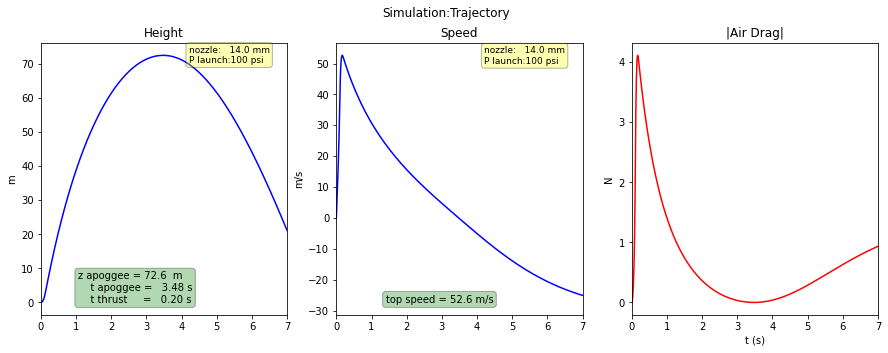

In [11]:
plot_trajectory()

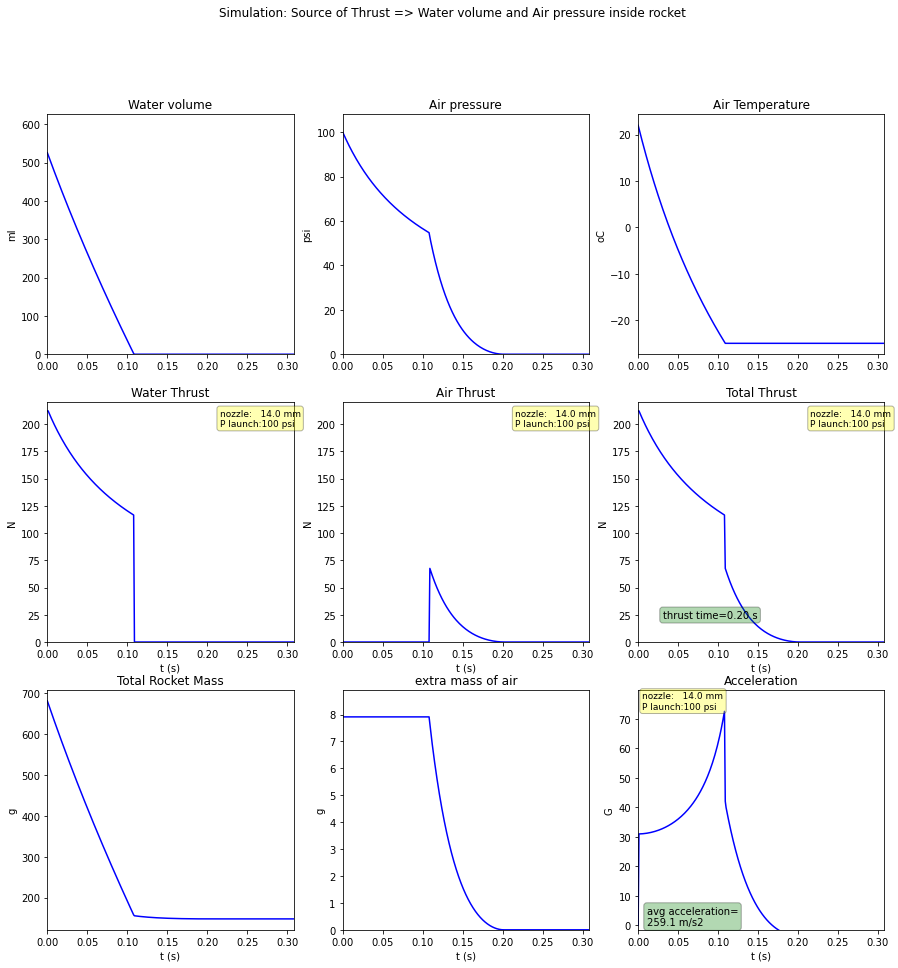

t water ends = 108.0 ms


In [12]:
plot_simulation()